In [1]:
import math
import numpy as np
import tbplas as tb
import sisl
from pathlib import Path

def add_orbitals(cell: tb.PrimitiveCell, positions, onsites, labels) -> None:
    """
    Add orbitals to the model.

    There are n_atoms atoms, with n_orbs orbitals each in that same position. We will extract those orbitals from the atom info.
    """
    for i in range(positions.shape[0]):
        n_orbs = len(labels[i])
        for j in range(n_orbs):
            cell.add_orbital_cart(positions[i], unit=tb.ANG, energy=onsites[i*n_orbs+j], label=labels[i][j])


def add_hopping_terms(cell: tb.PrimitiveCell, iscs, orbs_in, orbs_out, hoppings) -> None:
    n_hops = len(iscs)
    for i in range(n_hops):
        cell.add_hopping(rn=iscs[i], orb_i=orbs_in[i], orb_j=orbs_out[i], energy=hoppings[i])

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt


#Find the "Fermi Energy" from the DOS
def FindFermi2(energies, dos, N_orbitals, N_electrons, mode='linear', ShowPlot=False):
    """
    Estimates from the DOS the lowest energy E_Fermi such that the total number of states below E_Fermi is equal to the number of filled states. Expects a spinless calculation.
    INPUTS:
    energies, np.array of floats: the energies for which the DOS was computed.
    dos, np.array of floats: the corresponding dos values.
    N_orbitals: the total number of orbitals in the system (e.g. 12 per atom in a typical SIESTA calculation)
    N_electrons: the total number of electrons in the system (so in a typical BN calculation without spin, 3 per B atom and 5 per N atom)
    mode, string: see code. One would expect linear is to be better usually.
    showPlot, bool: if True, displays a plot showing graphically the determination of E_Fermi.
    OUTPUTS:
    E_Fermi: estimate of the lowest energy such that the total number of states below that energy is equal to the number of filled states.
    """

    cross_val=N_electrons/2  #number of filled SPINLESS states.

    cum_int=integrate.cumulative_trapezoid(dos, energies, initial=0)  #cumulative integral providing (possibly up to normalization) the number of filled states up to a given energy
    cum_int=N_orbitals*cum_int/cum_int[-1]  #enforce normalisation (typically very close to 1 without it, but if cum_int(E) is flat near E_f, a small normalization error can yield very large E_fermi errors)
    ind_Fermi=np.argwhere(cum_int>cross_val)[0][0]  #the first index which passes the Fermi energy

    if mode=='discrete':
        E_Fermi=energies[ind_Fermi]  #we just return that value. A priori limited to energy mesh precision.

    if mode=='linear':
        x1=energies[ind_Fermi-1]  #the first energy below
        y1=cum_int[ind_Fermi-1]

        x2=energies[ind_Fermi]    #the first one after
        y2=cum_int[ind_Fermi]

        #we now linearly interpolate the DOS between these two points to get a better estimator for E_fermi
        E_Fermi=(cross_val-y1)*(x2-x1)/(y2-y1)+x1

    if ShowPlot:
        #plt.scatter(energies, cum_int)
        plt.plot(energies, cum_int, label=r'$\int_{-\infty}^E DOS(E^\prime)dE^\prime$')
        plt.axhline(cross_val, ls='dotted', color='red', label=r'$N_{electrons}/2$')
        plt.axvline(E_Fermi, label=rf'$E_F$ estimate: {E_Fermi:.3f}', color='black', ls='dashed')
        plt.legend()
        plt.xlabel(r'Energy $E$')
        plt.ylabel('(Cumulative) number of (spinless) states')
        plt.show()


    return E_Fermi

import matplotlib.pyplot as plt

def plot_accond(omegas, ac_cond, text=None):

    fig, ax1 = plt.subplots()

    # Plot the real part on the first y-axis
    ax1.plot(omegas, ac_cond.real, color='blue', label='Re σ')
    ax1.set_xlabel("Energy (eV)")
    ax1.set_ylabel("Re σ (e²/ħ)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    if text is not None:
        ax1.text(0.95, 0.95, text,
         transform=ax1.transAxes,
         ha='right', va='top',
         fontsize=10,
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()
    ax2.plot(omegas, ac_cond.imag, color='red', label='Im σ')
    ax2.set_ylabel("Im σ (e²/ħ)", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    fig.tight_layout()

    return fig

/home/alapena/miniconda3/envs/tbplas/lib/python3.12/site-packages/tbplas/cython/__init__.py:54: UserWarning: C++ hdf5 extension not found. HDF5 IO not usable.
  warnings.warn("C++ hdf5 extension not found. HDF5 IO not usable.")


In [ ]:
path = Path("../../dataset/SHARE_OUTPUTS_2_ATOMS/7bbb-6d51-41eb-9de4-329298202ebf")
file = sisl.get_sile(path / "aiida.HSX")
geometry = file.read_geometry()

In [3]:
# Define tight binding model for tbplas

# Empty cell
vectors = geometry.cell
cell = tb.PrimitiveCell(vectors, unit=tb.ANG)

# Add orbitals
positions = geometry.xyz #Angstrom
labels = [[orb.name() for orb in atom] for atom in geometry.atoms]

# To add the orbitals we need the onsite energies.
h = file.read_hamiltonian()
h_mat = h.tocsr().tocoo()

rows = h_mat.row
cols = h_mat.col
data = h_mat.data

# Main diagonal length:
n_diag = min(h_mat.shape[0], h_mat.shape[1])

# Loop through all diagonal elements
onsites = np.zeros(n_diag, dtype=data.dtype)
for i in range(n_diag):
    # Find where both row and col equal i
    mask = (rows == i) & (cols == i)
    vals = data[mask]
    if len(vals) > 0:
        onsites[i] = vals[0]  # In COO, there could be duplicates, but take the first
    else:
        onsites[i] = 0  # Or np.nan if you prefer

# onsites = 
add_orbitals(cell, positions, onsites, labels)

# Add hopping terms.
# We need to iterate though each nnz element of h and get the isc in a tuple, the orb_in, the orb_out and the hopping value.
nnz = len(data)
n_orbs = len(labels[0]) # Assuming all atoms have the same nr of orbitals
n_atoms = int(path.parts[-2].split("_")[-2])
iscs = []
orbs_in = []
orbs_out = []
hoppings = []
for k in range(nnz):
    row = rows[k]
    col = cols[k]
    if row != col:  # Only add hopping terms for off-diagonal elements
        iscs.append(geometry.o2isc(col))
        orbs_in.append(col % (n_atoms*n_orbs))
        orbs_out.append(row)
        hoppings.append(data[k])
    

add_hopping_terms(cell, iscs, orbs_in, orbs_out, hoppings)

# Get overlap

# To add the orbitals we need the onsite energies.
o = file.read_overlap()
o_mat = o.tocsr().tocoo()

rows = o_mat.row
cols = o_mat.col
data = o_mat.data

# Main diagonal length:
n_diag = min(o_mat.shape[0], o_mat.shape[1])

# Loop through all diagonal elements
onsites = np.zeros(n_diag, dtype=data.dtype)
for i in range(n_diag):
    # Find where both row and col equal i
    mask = (rows == i) & (cols == i)
    vals = data[mask]
    if len(vals) > 0:
        onsites[i] = vals[0]  # In COO, there could be duplicates, but take the first
    else:
        onsites[i] = 0  # Or np.nan if you prefer

# Add onsites to overlap
overlap = tb.PrimitiveCell(cell.lat_vec, cell.origin, 1.0)
for i in range(cell.num_orb):
    orbital = cell.orbitals[i]
    overlap.add_orbital(orbital.position, onsites[i])


# Add hopping terms to overlap

# We need to iterate though each nnz element of h and get the isc in a tuple, the orb_in, the orb_out and the hopping value.
nnz = len(data)
n_orbs = len(labels[0]) # Assuming all atoms have the same nr of orbitals
n_atoms = int(path.parts[-2].split("_")[-2])
iscs = []
orbs_in = []
orbs_out = []
hoppings = []
for k in range(nnz):
    row = rows[k]
    col = cols[k]
    if row != col:  # Only add hopping terms for off-diagonal elements
        iscs.append(geometry.o2isc(col))
        orbs_in.append(col % (n_atoms*n_orbs))
        orbs_out.append(row)
        hoppings.append(data[k])
        

add_hopping_terms(overlap, iscs, orbs_in, orbs_out, hoppings)

# AC Conductivity


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : ac_cond_demo

Using Eigen backend for diagonalization.
Using DefaultACCore backend.


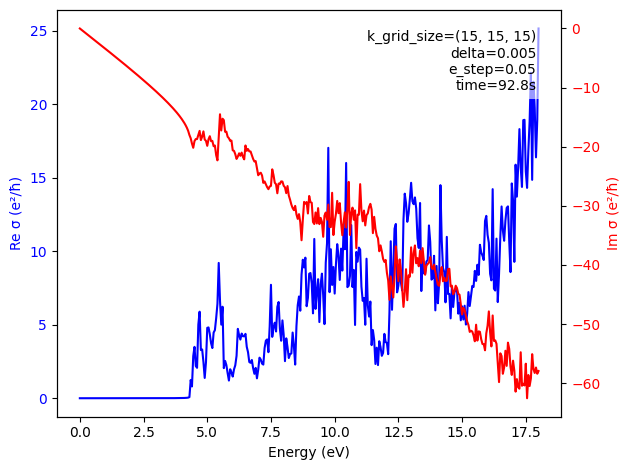

In [7]:
lind = tb.Lindhard(cell, overlap=overlap)
n_kpoints_accond = 15

e_step = 0.05
k_grid_size = (n_kpoints_accond, n_kpoints_accond, n_kpoints_accond)
delta = 0.005

cfg = lind.config
cfg.prefix       = "ac_cond_demo"   # basename for saved results (optional)
cfg.e_min        = 0            # energy (omega) range in eV
cfg.e_max        = 18
cfg.e_step       = e_step            # resolution (smaller → finer grid) default 0.05
cfg.dimension    = 3                # 2 for genuinely 2D materials
cfg.num_spin     = 2                # spin degeneracy
cfg.k_grid_size  = k_grid_size    # k-mesh (increase for convergence)
cfg.delta = delta
cfg.ac_cond_component = 1      # choose σ_xx, σ_yy, etc.

timer = tb.Timer()
timer.tic("ac_cond_demo")
omegas, ac_cond = lind.calc_ac_cond()
timer.toc("ac_cond_demo")
time=timer._time_usage["ac_cond_demo"]

text = f'k_grid_size={k_grid_size}\ndelta={delta}\ne_step={e_step}\ntime={time:.1f}s'
fig = plot_accond(omegas, ac_cond, text=text)
filename = text.replace('\n', '_') + '.png'
savedir = Path("../../results_ac_cond/study_convergence/8atm")
savedir.mkdir(exist_ok=True, parents=True)
filepath = savedir / filename
plt.savefig(filepath)
fig.show()